# single text(sentence) classification

- 과학 기술 태그(9) + 기술 문서 태그(4) = (11)
- 전처리 유무 : O
- Data Sampling : X

## module import

In [1]:
import torch
import pandas as pd
import numpy as np; import random
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

from transformers import BertForSequenceClassification, BertTokenizerFast

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [3]:
## 경로 설정
vocab_path: str = '/disk/changdae/TechBERT/vocab/'
model_path: str = '/disk/changdae/TechBERT/pretrained/40ep_train9/'
data_path: str = '/disk/changdae/TechBERT/data/total_v2.1.csv'
test_path: str = '/disk/changdae/TechBERT/data/etri_changdae_AFTER.csv'
output_path: str = './finetune_output/'

In [4]:
# randomness 제어
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
set_seed(12345)

In [7]:
# import wandb
# !wandb login 

## Load Dataset

In [5]:
df = pd.read_csv(data_path)
print(df.shape)
print(df.isna().sum())
df.head()

(185478, 3)
text      0
tag       0
source    0
dtype: int64


,text,tag,source
0,비접촉식 상황인지 센서: 움직이는 대상물 탐지센서,기술의 파급효과,etri
1,"비접촉 생체신호 모니터링 의료용기기, 헬스케어모니터링 기기",기술의 파급효과,etri
2,차량내 운전자 상태 모니터링 센서,기술의 파급효과,etri
3,"강설량 측정, 비파괴 벽투과 센서",기술의 파급효과,etri
4,재난 안전 모니터링용 센서 및 안전 사고후 비가시 영역 탐지 센서,기술의 파급효과,etri


In [6]:
# 결측치 제거
df = df.dropna()

s = df.source=='etri' # etri train data에서 제거
df = df[~s].reset_index(drop=True)

In [7]:
# etri load
test_df = pd.read_csv(test_path, encoding='cp949')
print(test_df.shape)
print(test_df.isna().sum())
test_df.tag = test_df.tag.replace({'기술의필요성':'기술의 필요성'})
test_df.tag = test_df.tag.replace({'기술동향':'기술의 파급효과'})
test_df.head()

(33773, 4)
text      0
tag       0
source    0
doc_id    0
dtype: int64


,text,tag,source,doc_id
0,다매체 다중경로 적응적 네트워크 최적화 기술,기술명,etri,0
1,국방망과 같은 절대적 생존을 요구하는 주요 통신망은 다수개의 망을 설치하여 유사시 ...,기술개요,etri,0
2,"또한, 데이터센터, 에지 클라우드에서는 전송해야 하는 데이터양이 급증하고 있으며, ...",기술개요,etri,0
3,"따라서, 가용한 모든 통신 인프라를 동시에 사용하여 네트워크 자원의 낭비를 막고 통...",기술개요,etri,0
4,본 기술은 다매체 다중경로 네트워크에 대한 적응적 제어 기술을 이용해 트래픽을 여러...,기술개요,etri,0


- input : text
- label : tag

In [8]:
# y dict 생성
possible_labels = df.tag.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

# label encoding
df['labels'] = df.tag.replace(label_dict)

test_df = test_df[test_df.tag.apply(lambda x: x in label_dict.keys())]
test_df['labels'] = test_df.tag.replace(label_dict)

In [9]:
label_dict

{'성능/효과': 0,
 '제안 방법': 1,
 '대상 데이터': 2,
 '문제 정의': 3,
 '이론/모형': 4,
 '후속연구': 5,
 '기술 정의': 6,
 '데이터처리': 7,
 '가설 설정': 8,
 '시장동향': 9,
 '기술의 파급효과': 10,
 '기술동향': 11,
 '기술의 필요성': 12}

In [10]:
set_seed(12345)
# train : valid = 70 : 30 /// test : etri dataset
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.labels.values, 
                                                  test_size=0.30, random_state=12345, stratify=df.labels.values)
X_val, X_test, y_val, y_test = train_test_split(df.loc[X_val].index.values, df.loc[X_val].labels.values, 
                                                  test_size=0.66, random_state=12345, stratify=df.loc[X_val].labels.values)

In [11]:
train, val = df.loc[X_train, ['text', 'labels']].reset_index(drop=True), df.loc[X_val, ['text', 'labels']].reset_index(drop=True)
test = pd.concat([df.loc[X_test, ['text', 'labels']].reset_index(drop=True),
                    test_df.loc[:, ['text', 'labels']].reset_index(drop=True)], axis=0) ## 20% + etri

In [12]:
# make Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)
dataset = DatasetDict({"train": train_dataset, "val": val_dataset, "test": test_dataset})

In [13]:
example = train_dataset[0]
print(example)

{'text': '이상의 결과들로부터 HepG2/2E1 세포에서 알코올 처리에 의한 세포의 CAT, GST, SOD, GPx, GR, GSH 함량의 감소 및 지질과산화물의 증가는 알코올 처리에 의한 자유라디칼의 급격한 증가에 의한 것으로 생각되며 발효울금 냉수 추출물은 이러한 자유라디칼을 제거하는 항산화 효소들을 효과적으로 활성화하고 GSH 함량을 증가 및 지질과산화물의 증가를 감소시킴으로써 알코올성 산화스트레스로부터 간 보호 효과가 있는 것으로 확인되었다.', 'labels': 0}


In [14]:
dataset['train'].num_rows

123352

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


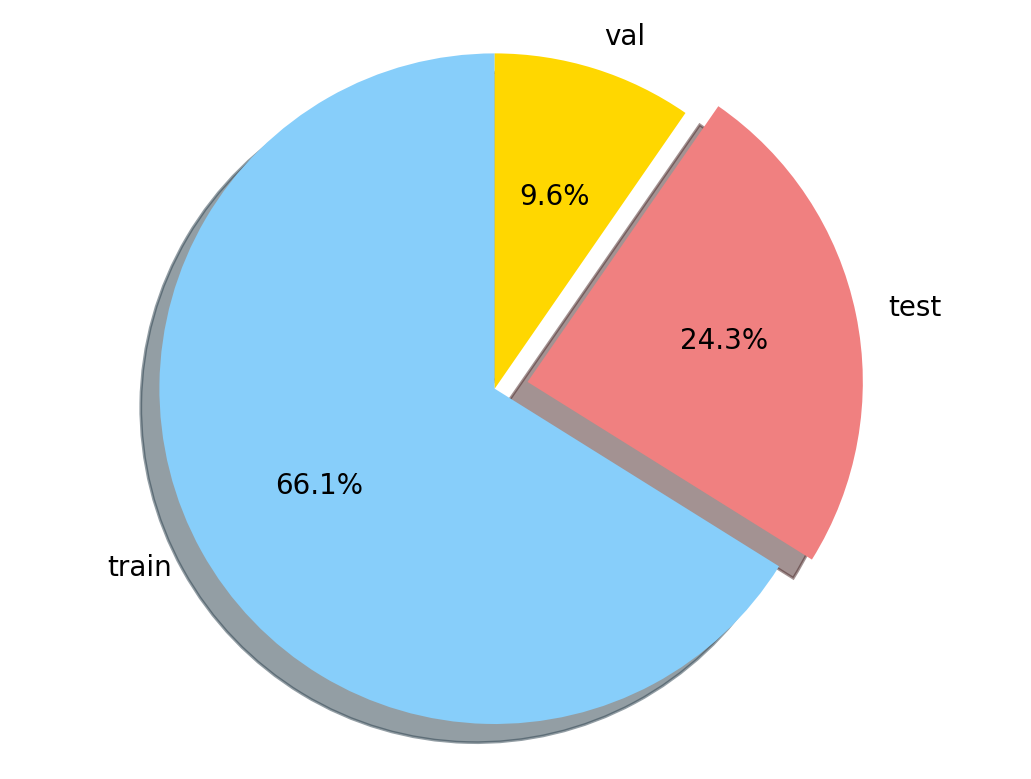

In [15]:
labels = ['train', 'test', 'val']
sizes = [dataset['train'].num_rows, dataset['test'].num_rows, dataset['val'].num_rows]
colors = ['lightskyblue', 'lightcoral', 'gold']#, yellowgreen
explode = (0, 0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()

In [16]:
!TOKENIZERS_PARALLELISM=false
!CUDA_VISIBLE_DEVICES=0

## tokenizer load 
- __call__ : https://github.com/huggingface/transformers/blob/v4.20.1/src/transformers/tokenization_utils_base.py#L2409

In [17]:
tokenizer = BertTokenizerFast.from_pretrained(vocab_path, do_lower_case=False, model_max_length=128)
print(tokenizer.__class__)
## vocab 확인
sorted(tokenizer.vocab.items(), key = lambda item: item[1])[:10]

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


[('[PAD]', 0),
 ('[UNK]', 1),
 ('[CLS]', 2),
 ('[SEP]', 3),
 ('[MASK]', 4),
 ('!', 5),
 ('"', 6),
 ('#', 7),
 ('$', 8),
 ('%', 9)]

In [18]:
from typing import Union, List, Dict

def transform(sentences: Union[str, List[str]], tokenizer) -> Dict[str, List[List[int]]]:
    if isinstance(sentences, str):
        sentences = [sentences]
    return tokenizer(text=sentences, add_special_tokens=True, padding=False, truncation=True, max_length = 128) ## Modify

In [19]:
samples = train_dataset[:2]
transformed_samples = transform(samples["text"], tokenizer)

print(samples)
print(transformed_samples)

{'text': ['이상의 결과들로부터 HepG2/2E1 세포에서 알코올 처리에 의한 세포의 CAT, GST, SOD, GPx, GR, GSH 함량의 감소 및 지질과산화물의 증가는 알코올 처리에 의한 자유라디칼의 급격한 증가에 의한 것으로 생각되며 발효울금 냉수 추출물은 이러한 자유라디칼을 제거하는 항산화 효소들을 효과적으로 활성화하고 GSH 함량을 증가 및 지질과산화물의 증가를 감소시킴으로써 알코올성 산화스트레스로부터 간 보호 효과가 있는 것으로 확인되었다.', '본 연구에 사용한 대두(Glycine max L.)는 2014년 10월에 수확된 대원(Daewone), 대풍2(Daepung2), 우람(Uram), 진풍(Jinpoung) 및 새단백(Saedanbaek) 총 5종으로(Table 1) 국립식량과학원(Miryang, Korea)에서 제공받아 사용하였다.'], 'labels': [0, 2]}
{'input_ids': [[5374, 5040, 10445, 19558, 2679, 2791, 2521, 19, 22, 2580, 2644, 36338, 11840, 19503, 5571, 15647, 19460, 2577, 16, 9994, 2577, 16, 23605, 2872, 16, 18584, 2629, 16, 43, 2822, 16, 9994, 2574, 19957, 2490, 5548, 1001, 17638, 2558, 17162, 2490, 30145, 11840, 19503, 5571, 5511, 2475, 2668, 2842, 2490, 19052, 21845, 5571, 4919, 4961, 5432, 9205, 2970, 2712, 417, 2501, 16578, 2646, 5109, 5511, 2475, 2668, 2842, 2533, 13999, 18836, 14842, 4922, 10525, 6507, 4865, 9994, 2574, 26175, 5153, 1001, 17638, 2558, 17162, 2490, 23467, 5548, 1

In [20]:
train_ds = train_dataset.map(lambda data: transform(data["text"], tokenizer), remove_columns=["text"], batched=True)
valid_ds = val_dataset.map(lambda data: transform(data["text"], tokenizer), remove_columns=["text"], batched=True)
test_ds = test_dataset.map(lambda data: transform(data["text"], tokenizer), remove_columns=["text"], batched=True)

  0%|          | 0/124 [00:00<?, ?ba/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/46 [00:00<?, ?ba/s]

<AxesSubplot:ylabel='Count'>

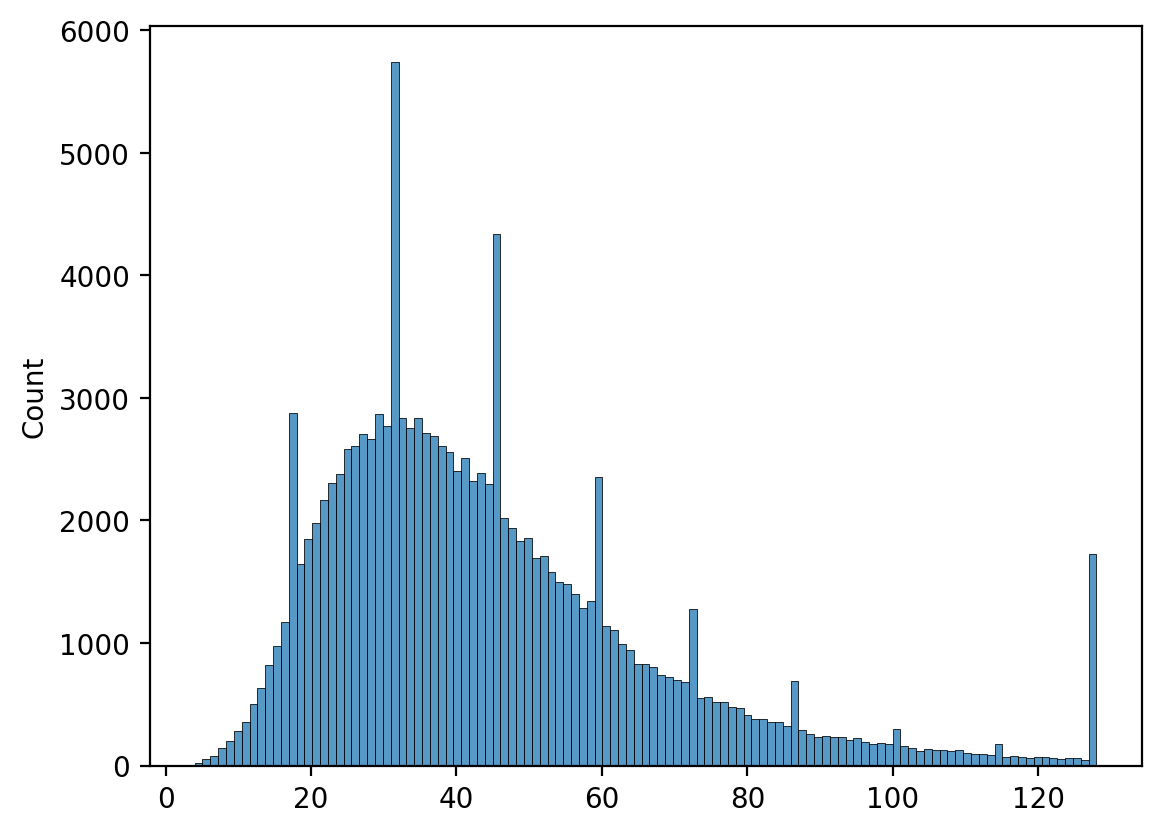

In [21]:
# truncation 확인
sns.histplot([len(i) for i in train_ds['input_ids']])

# Model Load

In [22]:
# BERT Pre-trained Model
model = BertForSequenceClassification.from_pretrained(model_path,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at /disk/changdae/TechBERT/pretrained/40ep_train9/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceCl

In [23]:
from transformers.data.data_collator import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    f1_micro = f1_score(y_true=labels, y_pred=pred, average='micro')
    f1_macro = f1_score(y_true=labels, y_pred=pred, average='macro')
    recall = recall_score(y_true=labels, y_pred=pred, average='micro')
    precision = precision_score(y_true=labels, y_pred=pred, average='micro')
    
    return {"accuracy": accuracy, "f1_micro": f1_micro, 'f1_macro': f1_macro, 'recall': recall, 'precision': precision}

batchify = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding="longest",
)

In [24]:
# mini-batch 구성확인
batchify(train_ds[:2])

{'labels': tensor([0, 2]), 'input_ids': tensor([[ 5374,  5040, 10445, 19558,  2679,  2791,  2521,    19,    22,  2580,
          2644, 36338, 11840, 19503,  5571, 15647, 19460,  2577,    16,  9994,
          2577,    16, 23605,  2872,    16, 18584,  2629,    16,    43,  2822,
            16,  9994,  2574, 19957,  2490,  5548,  1001, 17638,  2558, 17162,
          2490, 30145, 11840, 19503,  5571,  5511,  2475,  2668,  2842,  2490,
         19052, 21845,  5571,  4919,  4961,  5432,  9205,  2970,  2712,   417,
          2501, 16578,  2646,  5109,  5511,  2475,  2668,  2842,  2533, 13999,
         18836, 14842,  4922, 10525,  6507,  4865,  9994,  2574, 26175,  5153,
          1001, 17638,  2558, 17162,  2490, 23467,  5548, 11415, 11840,  2508,
          6149,  4977,  6211,  5070,   103,  5600,  6872,  4869,  4919, 22715,
            18],
        [ 1067, 13871,  8229, 15690,    12, 16480, 14278,  7573,    81, 12437,
            48,    18,    13,   510,  6980, 30890, 12825,  2845, 16238,   

In [26]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=output_path,          
    evaluation_strategy="epoch",
    eval_steps=1000,
    per_device_train_batch_size=128, 
    per_device_eval_batch_size=128,
    learning_rate=1e-4,
    weight_decay=0.01,
    adam_beta1=.9,
    adam_beta2=.95,
    adam_epsilon=1e-8,
    max_grad_norm=1.,
    optim = 'adamw_hf',
    num_train_epochs=50,    
    lr_scheduler_type="linear",
    warmup_steps=100,
    logging_dir='./logs',
    logging_strategy="epoch",
    logging_first_step=True,
    logging_steps=1000,
    save_strategy="epoch",
    seed=12345,
    dataloader_drop_last=False,
    dataloader_num_workers=2,
    report_to = 'wandb',
    run_name="TechBERT",  # name of the W&B run (optional)
    load_best_model_at_end =True, # Training이 끝났을 때 
    metric_for_best_model ='accuracy' # 모델 비교를 위한 metric, 지정하지 않을 경우 loss
)

trainer = Trainer(
    args=training_args,
    data_collator=batchify,
    model=model,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics
)

trainer.train()

/home1/hyez/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 123381
  Num Epochs = 50
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 1
  Total optimization steps = 12050
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: hyez. Use `wandb login --relogin` to force relogin


/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall,Precision
1,0.629100,0.343773,0.873690,0.873690,0.816539,0.873690,0.873690
2,0.291600,0.339128,0.879023,0.879023,0.816638,0.879023,0.879023
3,0.208800,0.361984,0.880536,0.880536,0.832022,0.880536,0.880536
4,0.142600,0.402230,0.875884,0.875884,0.822837,0.875884,0.875884
5,0.101100,0.463059,0.872537,0.872537,0.821653,0.872537,0.872537
6,0.071800,0.518598,0.874504,0.874504,0.827921,0.874504,0.874504
7,0.058200,0.546950,0.873293,0.873293,0.818495,0.873293,0.873293
8,0.046600,0.564803,0.872140,0.872140,0.826152,0.872140,0.872140
9,0.039100,0.641171,0.871951,0.871951,0.815478,0.871951,0.871951
10,0.034300,0.679754,0.867847,0.867847,0.818950,0.867847,0.867847


***** Running Evaluation *****
  Num examples = 52878
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-241
Configuration saved in ./output/checkpoint-241/config.json
Model weights saved in ./output/checkpoint-241/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 52878
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-482
Configuration saved in ./output/checkpoint-482/config.json
Model weights saved in ./output/checkpoint-482/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a 

Configuration saved in ./output/checkpoint-3856/config.json
Model weights saved in ./output/checkpoint-3856/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 52878
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-4097
Configuration saved in ./output/checkpoint-4097/config.json
Model weights saved in ./output/checkpoint-4097/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples

/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 52878
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-7712
Configuration saved in ./output/checkpoint-7712/config.json
Model weights saved in ./output/checkpoint-7712/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 52878
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-7953
Configuration saved in ./output/checkpoint-795

***** Running Evaluation *****
  Num examples = 52878
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-11327
Configuration saved in ./output/checkpoint-11327/config.json
Model weights saved in ./output/checkpoint-11327/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 52878
  Batch size = 512
Saving model checkpoint to ./output/checkpoint-11568
Configuration saved in ./output/checkpoint-11568/config.json
Model weights saved in ./output/checkpoint-11568/pytorch_model.bin
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze a

TrainOutput(global_step=12050, training_loss=0.03897960951343117, metrics={'train_runtime': 11428.891, 'train_samples_per_second': 539.777, 'train_steps_per_second': 1.054, 'total_flos': 4.0580797173160704e+17, 'train_loss': 0.03897960951343117, 'epoch': 50.0})

In [25]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=output_path,          
    evaluation_strategy="epoch",
    eval_steps=1000,
    per_device_train_batch_size=512,          #! 128 -> 512
    per_device_eval_batch_size=512,           #! 128 -> 512
    learning_rate=5e-5,                       #! 1e-4 -> 5e-5
    weight_decay=0.001,                       #! 1e-2 -> 1e-3
    adam_beta1=.9,
    adam_beta2=.95,
    adam_epsilon=1e-8,
    max_grad_norm=1.,
    optim = 'adamw_hf',
    num_train_epochs=10,    
    lr_scheduler_type="linear",
    warmup_steps=40,
    logging_dir='./logs',
    logging_strategy="epoch",
    logging_first_step=True,
    logging_steps=1000,
    save_strategy="epoch",
    seed=12345,
    dataloader_drop_last=False,
    dataloader_num_workers=2,
    report_to = 'wandb',
    run_name="TechBERT",  # name of the W&B run (optional)
    load_best_model_at_end =True, # Training이 끝났을 때 
    metric_for_best_model ='accuracy' # 모델 비교를 위한 metric, 지정하지 않을 경우 loss
)

trainer = Trainer(
    args=training_args,
    data_collator=batchify,
    model=model,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics
)

trainer.train()

/home/changdae/anaconda3/envs/techbert/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 123352
  Num Epochs = 10
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 2048
  Gradient Accumulation steps = 1
  Total optimization steps = 610
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: changdaeoh. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KeyboardInterrupt: 

## Evaluate

In [101]:
trainer.evaluate(test_ds)

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 45260
  Batch size = 512
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.0252141952514648,
 'eval_accuracy': 0.7577993813521874,
 'eval_f1_micro': 0.7577993813521874,
 'eval_f1_macro': 0.759722856553059,
 'eval_recall': 0.7577993813521874,
 'eval_precision': 0.7577993813521874,
 'eval_runtime': 34.3698,
 'eval_samples_per_second': 1316.856,
 'eval_steps_per_second': 2.589,
 'epoch': 50.0}

## predict

In [102]:
out = trainer.predict(test_ds)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 45260
  Batch size = 512
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [103]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
y_true = out[1]
y_pred = np.argmax(out[0], axis=1)

print('-'*10, 'confusion matrix(row:true, column:prediction)', '-'*10)
print(confusion_matrix(y_true, y_pred))
print('\n\n', '-'*10, 'classification report', '-'*10)
print(classification_report(y_true, y_pred, target_names=list(label_dict.keys())))

---------- confusion matrix(row:true, column:prediction) ----------
[[6644  103   24   14    8  170   31    7    7    1    0    0    0]
 [  64 3401  361  510  159    8   18  249   13    0    0    0    0]
 [  47  232 3568   28   64    6   12   25    6    0    0    0    0]
 [  12  219    5 2684    8   12    1    4    2    0    0    0    0]
 [   7  222   39   13 1765    1   27  130    0    0    0    0    0]
 [ 147    6    1   25    0 3313    2    2    1    2    0    0    0]
 [   9   13   23    2   16    0 2369    0    2    1    0    0    0]
 [   9  158   31   10   67    0    4 2400    1    0    0    0    0]
 [   6    7    5    4    4    2    4    1  575    0    0    0    0]
 [   3    2    3    0    0    2    2    0    0 2982   25  172   66]
 [ 104   22   21   13   12  240   21    2    6  940 2728  478  553]
 [   0    1    5    0    0    0    0    0    0  253   16  673   43]
 [ 224   85   68  196   14  279  168    4    8 2663  501  313 1196]]


 ---------- classification report ----------


In [38]:
label_dict_inv = {v: i for i, v in label_dict.items()}

mydict = {'target' :[],
            'prediction': [],
          'text' :[]}
for t in range(13):
    for p in range(13):
        true, pred = t, p
        pred_df = pd.DataFrame({'prediction':y_pred.tolist(), 'target':y_true.tolist()})
        if pred_df[(pred_df.prediction==pred)&(pred_df.target==true)].shape[0] != 0:
            
            for i in test.iloc[list(pred_df[(pred_df.prediction==pred)&(pred_df.target==true)].index)].text:
                mydict['prediction'].append(label_dict_inv[p])
                mydict['target'].append(label_dict_inv[t])
                mydict['text'].append(i)

pd.DataFrame(mydict).to_csv('./error_test.csv', encoding='utf-8-sig', index = False)

In [19]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# labels = list(range(len(label_dict)))
# sizes = pd.Series(dataset['train']['labels']).value_counts().tolist()
# ax[0].pie(sizes, labels=labels,autopct='%1.1f%%')
# ax[0].set_title('Percentage of target values')

# sizes = confusion_matrix(y_true, y_pred).sum(axis=0)
# ax[1].pie(sizes, labels=labels,autopct='%1.1f%%')
# ax[1].set_title('Percentage of predicted values')

# plt.axis('equal')
# plt.show()